Traing process and results of experiment 1.

In [1]:
import sys
sys.path.append('..')
from kmade.core import *
import torch
import os
import numpy as np
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

$x_1=sin(\theta)+n_1,x_2=cos(\theta)+n_2$

$p(x_1,x_2|\theta)=N(x_1-sin(\theta)|0,0.1^2)N(x_2-cos(\theta)|0,0.1^2)$

In [2]:
def generate_data(num_samples,seed=2024):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    x = torch.rand(num_samples) * 2 * torch.pi
    n1 = torch.normal(mean=0, std=0.1, size=(num_samples,))
    n2 = torch.normal(mean=0, std=0.1, size=(num_samples,))
    
    y1 = torch.sin(x) + n1
    y2 = torch.cos(x) + n2
    
    return torch.column_stack((y1, y2, x)).to(device)

data_para_train = generate_data(4000,seed=2024)
data_para_test = generate_data(4000,seed=2025)
#Use the data as a label in the loss function to compute u
dataset={'train_data':data_para_train,'test_data':data_para_test}

In [3]:
model=CSGKMADE(data_l=2,para_l=1,hidden_layers=[],para_hidden_layers=[],grid=5,k=3,seed=2024,input_order='sequential',mode='random',ckpt_path='checkpoints/made',device=device,ifperturb=True,bias_mean=0.0,bias_std=2.0);

checkpoint directory created: checkpoints/made
saving model version 0.0


In [4]:
model.fit(dataset=dataset,opt='LBFGS',steps=30,lr=1e-6,loss_fn=loss_function);
model.fit(dataset=dataset,opt='LBFGS',steps=450,lamb=1e-1,lr=1e-2,loss_fn=loss_function);

| train_loss: -1.74e+00 | test_loss: -1.73e+00 | reg: 5.73e+00 | : 100%|█| 30/30 [00:06<00:00,  4.76


saving model version 0.1


| train_loss: -1.78e+00 | test_loss: -1.76e+00 | reg: 3.83e-01 | : 100%|█| 450/450 [01:33<00:00,  4.


saving model version 0.2


In [5]:
os.makedirs('outputs', exist_ok=True)
model.saveckpt(path='outputs/experiment2')

In [6]:
model.auto_symbolic()

fixing (0,0,0) with 0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with 0
fixing (0,2,0) with sin, r2=0.9997882779726519, c=2
fixing (0,2,1) with sin, r2=0.9999665858876003, c=2
fixing (0,2,2) with 0, r2=0.0, c=0
fixing (0,2,3) with 0, r2=0.0, c=0
saving model version 0.3


In [7]:
#bigger dataset
data_para_train=generate_data(50000)
data_para_test=generate_data(50000)
#Use the data as a label in the loss function to compute u
dataset={'train_data':data_para_train,'test_data':data_para_test}

In [8]:
model.fit(dataset=dataset,opt='Adam',steps=400,lr=1e-5,loss_fn=loss_function);

| train_loss: -1.77e+00 | test_loss: -1.77e+00 | reg: 0.00e+00 | : 100%|█| 400/400 [00:14<00:00, 28.

saving model version 0.4


In [9]:
save_expr(model,'outputs/experiment2')

In [3]:
symbolic=True
if symbolic:
    sample_kmade=sampler(para=[0],n_samples=50000,path='outputs/experiment2')
else:
    model=load_model('outputs/experiment2')
    sample_kmade=model.sample(n_samples=50000,para=[0]).detach().cpu().numpy()

x1=np.random.normal(0,0.1,size=50000)
x2=1+np.random.normal(0,0.1,size=50000)
sample_true=np.column_stack((x1,x2))

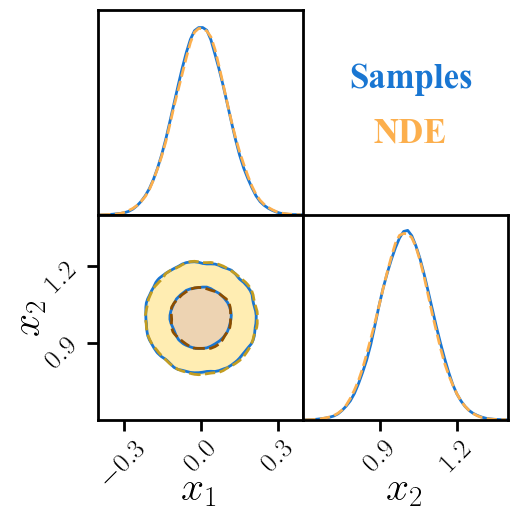

In [11]:
contour_kwargs={'colors1':['#1976d2'],
                'colors2':['#c39d21','#8d4e00'],
                'levels':[0.5,0.9],
                'width':[2,2],
                'linestyles':['-','--'],
                'smooth':1,
                'alpha':1}
contourf_kwargs={'colors':['white','#ffedb2','#edd3b2']}
hist_kwargs={'color':['#1976d2','#fcaf4d'],
             'width':[2,2],
             'alpha':1,
             'bins':50,
             'smooth1d':1}
var_kwargs={'names':[r"$x_{1}$",r"$x_{2}$"],
            'ranges':[(-0.4,0.4),(0.6,1.4)],
            'size':30,
            'weight':'normal',
            'pad':-0.05}
axes_kwargs={'width':2,
             'length':8,
             'size':20,
             'color':'black',
             'rotationx':45,'rotationy':45,
             'max_n_ticks':3}
legend_kwargs={'legend1':'Samples','legend2':'NDE',
              'loc1':(0.75,0.8),'loc2':(0.75,0.7),
              'size':25,
              'family':'Times New Roman',
              'weight1':'bold','weight2':'bold'}
corner_plot(sample_true,sample_kmade,
            path='outputs/experiment2_sym.pdf' if symbolic else 'outputs/experiment2_nn.pdf',
            contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,hist_kwargs=hist_kwargs,
            var_kwargs=var_kwargs,axes_kwargs=axes_kwargs,legend_kwargs=legend_kwargs)

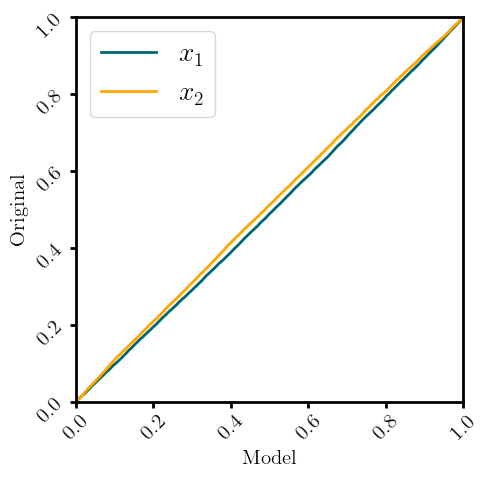

In [12]:
axes_kwargs={'width':2,
             'size':15,
             'weight':'normal',
             'length':4,
             'color':'black',
             'rotationx':45,'rotationy':45}
legend_kwargs={'loc':'best',
               'color':'black',
               'ls':[],
               'handlelength':2,
               'prop':{'size':20}}
title_kwargs={'content':'',
              'size':12,
              'color':'black',
              'family':'Times New Roman',
              'weight':'bold',
              'pad':0.05,
              'if_title':False}
label_kwargs={'label1':'Model','label2':'Original',
              'size':15,
              'family':'Times New Roman',
              'color1':'black','color2':'black',
              'weight1':'bold','weight2':'bold',
              'pad':0}
ref_kwargs={'color':'black',
             'width':2,
             'linestyle':'--',
             'alpha':1,
             'if_ref':False,}
pp_plot(color_bar=['#006573','#FFA700'],
        column_names=[r"$x_{1}$",r"$x_{2}$"],
        sample_lw=2,
        path='outputs/experiment2_sympp.pdf' if symbolic else 'outputs/experiment2_nnpp.pdf',
        sample1=sample_true,sample2=sample_kmade,
        axes_kwargs=axes_kwargs,
        legend_kwargs=legend_kwargs,
        title_kwargs=title_kwargs,
        label_kwargs=label_kwargs,
        ref_kwargs=ref_kwargs,)